\*\*\* HI this is my complete solution for kaggles predict future sales competition. I have attained first place in the competition.\*\*\*


# Introduction

This notebook is based on the work of these two notebooks. I ahve used their notebook for basic feature engineering. I had initially made my own notebook, but I kept it in a server and didnot make backup. My friend using that server accidentally deleted my folder. Using that notebook I got accuracy of 0.84 using basic features and no stacking model. I found these two notebooks quite similar to my code. So I used them. 
https://www.kaggle.com/code/deepdivelm/feature-engineering-lightgbm-exploring-performance
https://www.kaggle.com/code/deinforcement/top-1-predict-future-sales-features-lightgbm

If you have any questions please feel free to ask.




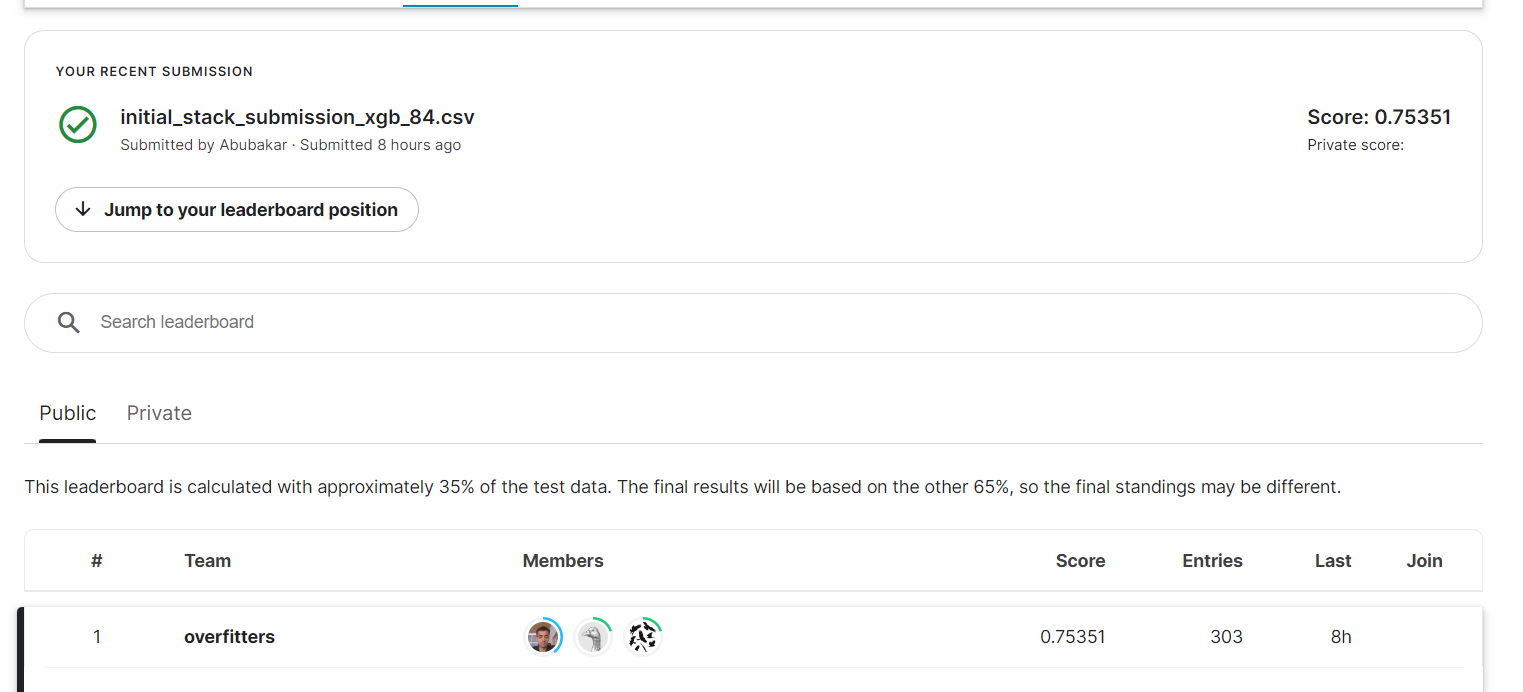

# Data loading and preprocessing, utility function definition

> ****Please Uncomment below Data Preparation part if you want to run whole code, I have commented out Data Preparation till Modelling because most of it is already done by other users. I am not much expert of Jupyter notebooks , so I donot know How to skip certain sections without if else statements. Please feel free to ask. DO read comments.

## Imports and data loading

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kaggle-predict-future-sales-first-place-solution/vals_arr_lgb_84s.npy
/kaggle/input/kaggle-predict-future-sales-first-place-solution/vals_arr_lgb_84.npy
/kaggle/input/kaggle-predict-future-sales-first-place-solution/vals_arr_xgb_84.npy
/kaggle/input/kaggle-predict-future-sales-first-place-solution/abubakar_VVIP/abubakar_VVIP/initial_stack_submission_xgb_84 (1).csv
/kaggle/input/kaggle-predict-future-sales-first-place-solution/abubakar_VVIP/abubakar_VVIP/vals_arr_xgb_84.pkl
/kaggle/input/kaggle-predict-future-sales-first-place-solution/abubakar_VVIP/abubakar_VVIP/items.csv
/kaggle/input/kaggle-predict-future-sales-first-place-solution/abubakar_VVIP/abubakar_VVIP/vals_arr_lgb_84.pkl
/kaggle/input/kaggle-predict-future-sales-first-place-solution/abubakar_VVIP/abubakar_VVIP/checkpoint_final_0.84.pkl
/kaggle/input/kaggle-predict-future-sales-first-place-solution/abubakar_VVIP/abubakar_VVIP/vals_arr_lgb_84s.pkl
/kaggle/input/kaggle-predict-future-sales-first-place-solution/abub

In [2]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

A few utility functions used throughout the notebook.

In [3]:
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

Load the provided data.

In [4]:
path="/kaggle/input/kaggle-predict-future-sales-first-place-solution/abubakar_VVIP/abubakar_VVIP/" # Please adjust this path according to your usage.
items = pd.read_csv(path+"items.csv")
shops = pd.read_csv(path+"shops.csv")
train = pd.read_csv(path+"sales_train.csv")
test = pd.read_csv(path+"test.csv")

Convert the date column to the datetime dtype to enable datetime operations.

In [5]:
# train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

## Data cleaning

The training dataframe is cleaned with standard steps  


In [6]:
# # Merge some duplicate shops
# train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
# # Keep only shops that are in the test set
# train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]
# # Drop training items with extreme or negative prices or sales counts
# train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
# train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

## Preprocessing

The test data seems to be every possible combination (the cartesian product) of shops and items that registered a sale in the test month, with the target as the total month's sales made for each of these shop-item combinations. Here a training matrix is made that replicates this structure for every month in the training data period. The test items are concatenated to the end of the training data so that features can be generated for the test period.

In [7]:
# def create_testlike_train(sales_train, test=None):
#     indexlist = []
#     for i in sales_train.date_block_num.unique():
#         x = itertools.product(
#             [i],
#             sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
#             sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
#         )
#         indexlist.append(np.array(list(x)))
#     df = pd.DataFrame(
#         data=np.concatenate(indexlist, axis=0),
#         columns=["date_block_num", "shop_id", "item_id"],
#     )

#     # Add revenue column to sales_train
#     sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
#     # Aggregate item_id / shop_id item_cnts and revenue at the month level
#     sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
#         item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
#         item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
#     )

#     # Merge the grouped data with the index
#     df = df.merge(
#         sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],
#     )

#     if test is not None:
#         test["date_block_num"] = 34
#         test["date_block_num"] = test["date_block_num"].astype(np.int8)
#         test["shop_id"] = test.shop_id.astype(np.int8)
#         test["item_id"] = test.item_id.astype(np.int16)
#         test = test.drop("ID",1)

#         df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

#     # Fill empty item_cnt entries with 0
#     df.item_cnt_month = df.item_cnt_month.fillna(0)
#     df.item_revenue_month = df.item_revenue_month.fillna(0)

#     return df

In [8]:
# matrix = create_testlike_train(train, test)
# del(test)

The function reduce_mem_usage downcasts datatypes to reduce memory usage, which is necessary to prevent memory overflow errors in the Kaggle notebook.

In [9]:
# matrix = reduce_mem_usage(matrix, silent=False)
# oldcols = matrix.columns

## Feature engineering  
In this section predictor feature columns are generated and added to the matrix

# Item name groups with fuzzywuzzy

Items in the items table are ordered alphabetically according to the item_name field, so that similar items are generally listed next to each other. For example, the first two items in the table below are the same game "Fuse" for two different consoles, followed by two different licensing options for the same internet security program. This ordering can be used to help group related items together.  

In [10]:
# items.query("item_id>3564").head(5)

The following cell groups similar items together by sequentially looping through items, measuring the similarity of the names of ajacent items using the string matching package fuzzywuzzy (https://github.com/seatgeek/fuzzywuzzy), and assigning items to the same group if their match value is above a threshold.

In [11]:
# import re

# from fuzzywuzzy import fuzz


# def add_item_name_groups(matrix, train, items, sim_thresh, feature_name="item_name_group"):
#     def partialmatchgroups(items, sim_thresh=sim_thresh):
#         def strip_brackets(string):
#             string = re.sub(r"\(.*?\)", "", string)
#             string = re.sub(r"\[.*?\]", "", string)
#             return string

#         items = items.copy()
#         items["nc"] = items.item_name.apply(strip_brackets)
#         items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

#         def partialcompare(s):
#             return fuzz.partial_ratio(s["nc"], s["ncnext"])

#         items["partialmatch"] = items.apply(partialcompare, axis=1)
#         # Assign groups
#         grp = 0
#         for i in range(items.shape[0]):
#             items.loc[i, "partialmatchgroup"] = grp
#             if items.loc[i, "partialmatch"] < sim_thresh:
#                 grp += 1
#         items = items.drop(columns=["nc", "ncnext", "partialmatch"])
#         return items

#     items = partialmatchgroups(items)
#     items = items.rename(columns={"partialmatchgroup": feature_name})
#     items = items.drop(columns="partialmatchgroup", errors="ignore")

#     items[feature_name] = items[feature_name].apply(str)
#     items[feature_name] = items[feature_name].factorize()[0]
#     matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left")
#     train = train.merge(items[["item_id", feature_name]], on="item_id", how="left")
#     return matrix, train


# matrix, train = add_item_name_groups(matrix, train, items, 65)

# Music artist / first word of item name  

This function assigns music items into groups according to the artist name, which is extracted from the item name with regular expressions according to 3 common patterns used to indicate the artist name (all uppercase, separated from the release title by a doublespace, or separated by dot-space (. ).  
For non-music categories, the items are grouped according to the first word in the item name instead.

In [12]:
# from nltk.corpus import stopwords


# def add_first_word_features(matrix, items=items, feature_name="artist_name_or_first_word"):
#     # This extracts artist names for music categories and adds them as a feature.
#     def extract_artist(st):
#         st = st.strip()
#         if st.startswith("V/A"):
#             artist = "V/A"
#         elif st.startswith("СБ"):
#             artist = "СБ"
#         else:
#             # Retrieves artist names using the double space or all uppercase pattern
#             mus_artist_dubspace = re.compile(r".{2,}?(?=\s{2,})")
#             match_dubspace = mus_artist_dubspace.match(st)
#             mus_artist_capsonly = re.compile(r"^([^a-zа-я]+\s)+")
#             match_capsonly = mus_artist_capsonly.match(st)
#             candidates = [match_dubspace, match_capsonly]
#             candidates = [m[0] for m in candidates if m is not None]
#             # Sometimes one of the patterns catches some extra words so choose the shortest one
#             if len(candidates):
#                 artist = min(candidates, key=len)
#             else:
#                 # If neither of the previous patterns found something, use the dot-space pattern
#                 mus_artist_dotspace = re.compile(r".{2,}?(?=\.\s)")
#                 match = mus_artist_dotspace.match(st)
#                 if match:
#                     artist = match[0]
#                 else:
#                     artist = ""
#         artist = artist.upper()
#         artist = re.sub(r"[^A-ZА-Я ]||\bTHE\b", "", artist)
#         artist = re.sub(r"\s{2,}", " ", artist)
#         artist = artist.strip()
#         return artist

#     items = items.copy()
#     all_stopwords = stopwords.words("russian")
#     all_stopwords = all_stopwords + stopwords.words("english")

#     def first_word(string):
#         # This cleans the string of special characters, excess spaces and stopwords then extracts the first word
#         string = re.sub(r"[^\w\s]", "", string)
#         string = re.sub(r"\s{2,}", " ", string)
#         tokens = string.lower().split()
#         tokens = [t for t in tokens if t not in all_stopwords]
#         token = tokens[0] if len(tokens) > 0 else ""
#         return token

#     music_categories = [55, 56, 57, 58, 59, 60]
#     items.loc[items.item_category_id.isin(music_categories), feature_name] = items.loc[
#         items.item_category_id.isin(music_categories), "item_name"
#     ].apply(extract_artist)
#     items.loc[items[feature_name] == "", feature_name] = "other music"
#     items.loc[~items.item_category_id.isin(music_categories), feature_name] = items.loc[
#         ~items.item_category_id.isin(music_categories), "item_name"
#     ].apply(first_word)
#     items.loc[items[feature_name] == "", feature_name] = "other non-music"
#     items[feature_name] = items[feature_name].factorize()[0]
#     matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left",)
#     return matrix


# matrix = add_first_word_features(
#     matrix, items=items, feature_name="artist_name_or_first_word"
# )

# Item name length as a feature
The name of the item_name field is surprisingly predictive, presumably because similar items often have similar length names. This is recorded both from the raw item name and the name cleaned of special characters and bracketed terms, which often contain information about release formats that obscure similarities between items.

In [13]:
# import re
# def clean_item_name(string):
#     # Removes bracketed terms, special characters and extra whitespace
#     string = re.sub(r"\[.*?\]", "", string)
#     string = re.sub(r"\(.*?\)", "", string)
#     string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
#     string = re.sub(r"\s{2,}", " ", string)
#     string = string.lower()
#     return string

# items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
# items["item_name_length"] = items["item_name"].apply(len)
# matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')
# items = items.drop(columns=['item_name_length', 'item_name_cleaned_length'])

In [14]:
# print("Created name features")
# matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Time features
Day and month-resolution time features are created from the training dataframe, e.g. number of days since the first and last sale of each item.

The time since the first sale of each items is also used to create a mean sales-per-day feature ("item_cnt_day_avg"), which is potentially useful to correct sales counts for items which are less than a month old and therefore were not available to buy for the entire preceding month.  

In [15]:
# def add_time_features(m, train, correct_item_cnt_day=False):
#     from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

#     def item_shop_age_months(m):
#         m["item_age"] = m.groupby("item_id")["date_block_num"].transform(
#             lambda x: x - x.min()
#         )
#         # Sales tend to plateau after 12 months
#         m["new_item"] = m["item_age"] == 0
#         m["new_item"] = m["new_item"].astype("int8")
#         m["shop_age"] = (
#             m.groupby("shop_id")["date_block_num"]
#             .transform(lambda x: x - x.min())
#             .astype("int8")
#         )
#         return m

#     # Add dummy values for the test month so that features are created correctly
#     dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
#     dummies = dummies.assign(
#         date=pd.to_datetime("2015-11-30"), item_price=1, item_cnt_day=0, item_revenue_day=0,
#     )
#     train = pd.concat([train, dummies])
#     del dummies

#     month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
#     month_last_day[~month_last_day.dt.is_month_end] = (
#         month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
#     )
#     month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
#     month_first_day[~month_first_day.dt.is_month_start] = (
#         month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
#     )
#     month_length = (month_last_day - month_first_day + Day()).rename("month_length")
#     first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
#     first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
#     first_shop_item_date = (
#         train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
#     )
#     first_item_name_group_date = (
#         train.groupby("item_name_group").date.min().rename("first_name_group_date")
#     )

#     m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
#     m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
#     m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
#     m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
#     m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
#     m = m.merge(
#         first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left"
#     )
#     m = m.merge(
#         first_item_name_group_date, left_on="item_name_group", right_index=True, how="left"
#     )

#     # Calculate how long the item was sold for in each month and use this to calculate average sales per day
#     m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
#     m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
#     m["item_in_shop_days"] = (
#         m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
#     )
#     m = m.drop(columns="item_first_sale_days")
#     m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]
#     m["month_length"] = m["month_length"].dt.days

#     # Calculate the time differences from the beginning of the month so they can be used as features without lagging
#     m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
#     m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
#     m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
#     m["first_name_group_sale_days"] = m["month_first_day"] - m["first_name_group_date"]
#     m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)
#     m["first_item_sale_days"] = (
#         m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
#     )
#     m["first_shop_item_sale_days"] = (
#         m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
#     )
#     m["first_name_group_sale_days"] = (
#         m["first_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
#     )

#     # Add days since last sale
#     def last_sale_days(matrix):
#         last_shop_item_dates = []
#         for dbn in range(1, 35):
#             lsid_temp = (
#                 train.query(f"date_block_num<{dbn}")
#                 .groupby(["shop_id", "item_id"])
#                 .date.max()
#                 .rename("last_shop_item_sale_date")
#                 .reset_index()
#             )
#             lsid_temp["date_block_num"] = dbn
#             last_shop_item_dates.append(lsid_temp)

#         last_shop_item_dates = pd.concat(last_shop_item_dates)
#         matrix = matrix.merge(
#             last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
#         )

#         def days_since_last_feat(m, feat_name, date_feat_name, missingval):
#             m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
#             m.loc[m[feat_name] > 2000, feat_name] = missingval
#             m.loc[m[feat_name].isna(), feat_name] = missingval
#             return m

#         matrix = days_since_last_feat(
#             matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999
#         )

#         matrix = matrix.drop(columns=["last_shop_item_sale_date"])
#         return matrix

#     m = last_sale_days(m)
#     # Month id feature
#     m["month"] = m["month_first_day"].dt.month

#     m = m.drop(
#         columns=[
#             "first_day",
#             "month_first_day",
#             "month_last_day",
#             "first_shop_date",
#             "first_item_date",
#             "first_name_group_date",
#             "item_in_shop_days",
#             "first_shop_item_date",
#             "month_length",
#         ],
#         errors="ignore",
#     )

#     m = item_shop_age_months(m)

#     if correct_item_cnt_day == True:
#         m["item_cnt_month_original"] = m["item_cnt_month"]
#         m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]

#     return m

In [16]:
# matrix = add_time_features(matrix, train, False)
# print("Time features created")

# Price features  

The price of the item in the last month in which it was sold, and its price relative to other items in the same category.

In [17]:
# def add_price_features(matrix, train):
#     # Get mean prices per month from train dataframe
#     price_features = train.groupby(["date_block_num", "item_id"]).item_price.mean()
#     price_features = pd.DataFrame(price_features)
#     price_features = price_features.reset_index()
#     # Calculate normalized differenced from mean category price per month
#     price_features = price_features.merge(
#         items[["item_id", "item_category_id"]], how="left", on="item_id"
#     )
#     price_features["norm_diff_cat_price"] = price_features.groupby(
#         ["date_block_num", "item_category_id"]
#     )["item_price"].transform(lambda x: (x - x.mean()) / x.mean())
#     # Retain only the necessary features
#     price_features = price_features[
#         [
#             "date_block_num",
#             "item_id",
#             "item_price",
#             "norm_diff_cat_price",
#         ]
#     ]

#     features = [
#         "item_price",
#         "norm_diff_cat_price",
#     ]
#     newnames = ["last_" + f for f in features]
#     aggs = {f: "last" for f in features}
#     renames = {f: "last_" + f for f in features}
#     features = []
#     for dbn in range(1, 35):
#         f_temp = (
#             price_features.query(f"date_block_num<{dbn}")
#             .groupby("item_id")
#             .agg(aggs)
#             .rename(columns=renames)
#         )
#         f_temp["date_block_num"] = dbn
#         features.append(f_temp)
#     features = pd.concat(features).reset_index()
#     matrix = matrix.merge(features, on=["date_block_num", "item_id"], how="left")
#     return matrix

In [18]:
# matrix = add_price_features(matrix, train)
# del(train)

# Item category features  
In addition to the item categories provided with the data, I also manually defined two additional category groupings - supercategory (e.g. "games", "music") and platform (e.g. "PS4", "mp3").

In [19]:
# matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

# platform_map = {
#     0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 1, 11: 2,
#     12: 3, 13: 4, 14: 5, 15: 6, 16: 7, 17: 8, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5,
#     23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 11,
#     34: 11, 35: 3, 36: 0, 37: 12, 38: 12, 39: 12, 40: 13, 41: 13, 42: 14, 43: 15,
#     44: 15, 45: 15, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14,
#     54: 8, 55: 16, 56: 16, 57: 17, 58: 18, 59: 13, 60: 16, 61: 8, 62: 8, 63: 8, 64: 8,
#     65: 8, 66: 8, 67: 8, 68: 8, 69: 8, 70: 8, 71: 8, 72: 8, 73: 0, 74: 10, 75: 0,
#     76: 0, 77: 0, 78: 0, 79: 8, 80: 8, 81: 8, 82: 8, 83: 8,
# }
# matrix['platform_id'] = matrix['item_category_id'].map(platform_map)

# supercat_map = {
#     0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 1,
#     13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3,
#     24: 3, 25: 0, 26: 2, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2,
#     35: 2, 36: 2, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5,
#     46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 6, 56: 6,
#     57: 6, 58: 6, 59: 6, 60: 6, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0,
#     68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7,
#     79: 2, 80: 2, 81: 0, 82: 0, 83: 0
# }
# matrix['supercategory_id'] = matrix['item_category_id'].map(supercat_map)

# Shop city
(from https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

In [20]:
# def add_city_codes(matrix, shops):
#     shops.loc[
#         shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
#     ] = 'СергиевПосад ТЦ "7Я"'
#     shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
#     shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
#     shops["city_code"] = shops["city"].factorize()[0]
#     shop_labels = shops[["shop_id", "city_code"]]
#     matrix = matrix.merge(shop_labels, on='shop_id', how='left')
#     return matrix

# matrix = add_city_codes(matrix, shops)
# del(shops)

# Shop and item category clustering

Shops and item categories are grouped into clusters according to their sales profiles. 
The following function performs and plots the results of a principle component analysis decomposition and clustering of the shops and item categories.

The proportion of explained variance between items explained by each of the PCA dimensions is plotted, and the individual items are plotted according to their scores on the PCA dimensions and coloured according to their cluster assignment.

The silhouette score (a metric of clustering quality) for different values of the cluster number parameter is also plotted. These plots were used to decide the number of clusters.

For both shops and item categories, over 80% of differences occur on a single dimension, indicating that differences are mainly in magnitude rather than proportion. The item component score plots show that the clustering is mainly into a large cluster containing the large majority of items, and a few clusters containing outlier items.

In [21]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.decomposition import PCA
# from sklearn.metrics import silhouette_score


# def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
#     start_month = 20
#     end_month = 32
#     pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
#     if exclude is not None:
#         pt = matrix[~matrix[clust_feature].isin(exclude)]
#     pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
#     pt = pt.transpose()
#     pca = PCA(n_components=10)
#     components = pca.fit_transform(pt)
#     components = pd.DataFrame(components)
#     # Plot PCA explained variance
#     sns.set_theme()
#     features = list(range(pca.n_components_))
#     fig = plt.figure(figsize=(10,4))
#     ax = fig.add_subplot(121)
# #     ax.bar(features, pca.explained_variance_ratio_, color="black")
#     sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
#     plt.title("Variance by PCA components")
#     plt.xlabel("component")
#     plt.ylabel("explained variance")
#     plt.xticks(features)

#     scorelist = []
#     nrange = range(2, 10)
#     for n in nrange:
#         clusterer = AgglomerativeClustering(n_clusters=n)
#         labels = clusterer.fit_predict(components)
#         silscore = silhouette_score(pt, labels)
#         scorelist.append(silscore)
#     ax = fig.add_subplot(122)
#     sns.lineplot(x=nrange, y=scorelist, ax=ax)
#     plt.title("Clustering quality by number of clusters")
#     plt.xlabel("n clusters")
#     plt.ylabel("silhouette score")

#     pca = PCA(n_components=n_components)
#     components = pca.fit_transform(pt)
#     components = pd.DataFrame(components)
#     clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
#     labels = clusterer.fit_predict(components)
#     x = components[0]
#     y = components[1]
#     fig = plt.figure(figsize=(10, 4))
#     ax = fig.add_subplot(111)
#     sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
#     plt.title("Items by cluster")
#     plt.xlabel("component 1 score")
#     plt.ylabel("component 2 score")
#     for i, txt in enumerate(pt.index.to_list()):
#         ax.annotate(str(txt), (x[i], y[i]))
#     groups = {}
#     for i, s in enumerate(pt.index):
#         groups[s] = labels[i]
#     return groups

Item categories are clustered according to their mean sales in each month of the year. The principle component plot shows that 3 categories are outliers in this respect.

In [22]:
# category_group_dict = cluster_feature(matrix, 'item_cnt_month', 'item_category_id', 'date_block_num', n_components=2, n_clusters=4, aggfunc="mean", exclude =[])
# matrix['category_cluster'] = matrix['item_category_id'].map(category_group_dict)

Shops are clustered by their summed sales of each item category. The principle component plots show that shops mainly differ in the magnitude of their sales, with shop 31 being an outlier due to the volume of its sales. Shops 12 and 55 are outliers on an orthogonal dimension because they sell different (online only) items.

In [23]:
# shop_group_dict = cluster_feature(matrix, 'item_cnt_month', 'shop_id', 'item_category_id', n_components=4, n_clusters=4, aggfunc="mean", exclude=[36])
# shop_group_dict[36] = shop_group_dict[37]  # Shop36 added separately because it only has one month of data
# matrix['shop_cluster'] = matrix['shop_id'].map(shop_group_dict)

In [24]:
# gc.collect()
# matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)  # Use this function periodically to downcast dtypes to save memory

# Number of unique item features

These features count the number of unique items sharing the same value of a grouping feature or set of features as the current item in the current month, e.g. number of new items in the same category.  

This could considered to be a kind of data leakage feature, as the set of items in each month (and therefore the test set) is determined by whether each item recorded a sale or not in the month being predicted, which isn't known in advance.

In [25]:
# def uniques(matrix, groupers, name, limitation=None):
#     if limitation is not None:
#         s = (
#             matrix.query(limitation)
#             .groupby(groupers)
#             .item_id.nunique()
#             .rename(name)
#             .reset_index()
#         )
#     else:
#         s = matrix.groupby(groupers).item_id.nunique().rename(name).reset_index()
#     matrix = matrix.merge(s, on=groupers, how="left")
#     matrix[name] = matrix[name].fillna(0)
#     return matrix


# matrix = uniques(matrix, ["date_block_num"], "unique_items_month")

# matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_unique_month")
# matrix = uniques(
#     matrix,
#     ["date_block_num", "item_category_id", "item_name_group"],
#     "name_group_cat_unique_month",
# )
# matrix = uniques(
#     matrix,
#     ["date_block_num", "item_name_group"],
#     "name_group_new_unique_month",
#     limitation="new_item==True",
# )
# matrix = uniques(
#     matrix,
#     ["date_block_num", "item_category_id", "item_name_group"],
#     "name_group_new_cat_unique_month",
#     limitation="new_item==True",
# )

# matrix = uniques(
#     matrix, ["date_block_num", "artist_name_or_first_word"], "first_word_unique_month"
# )
# matrix = uniques(
#     matrix,
#     ["date_block_num", "item_category_id", "artist_name_or_first_word"],
#     "first_word_cat_unique_month",
# )
# matrix = uniques(
#     matrix,
#     ["date_block_num", "artist_name_or_first_word"],
#     "first_word_new_unique_month",
#     limitation="new_item==True",
# )
# matrix = uniques(
#     matrix,
#     ["date_block_num", "item_category_id", "artist_name_or_first_word"],
#     "first_word_new_cat_unique_month",
#     limitation="new_item==True",
# )

# matrix = uniques(matrix, ["date_block_num", "item_category_id"], "unique_items_cat")
# matrix = uniques(
#     matrix,
#     ["date_block_num", "item_category_id"],
#     "new_items_cat",
#     limitation="new_item==True",
# )
# matrix = uniques(matrix, ["date_block_num"], "new_items_month", limitation="new_item==True")

# matrix["cat_items_proportion"] = matrix["unique_items_cat"] / matrix["unique_items_month"]
# matrix["name_group_new_proportion_month"] = (
#     matrix["name_group_new_unique_month"] / matrix["name_group_unique_month"]
# )

# matrix = matrix.drop(columns=["unique_items_month", "name_group_unique_month"])

In [26]:
# matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Percentage change in an aggregate feature  
This uses the pandas pct_change method to calculate the proportional change in mean sales count for a specific grouping for a specific time interval, e.g. increase / decrease in mean sales of an item between the last 2 months.

In [27]:
# def add_pct_change(
#     matrix,
#     group_feats,
#     target="item_cnt_month",
#     aggfunc="mean",
#     periods=1,
#     lag=1,
#     clip_value=None,
# ):
#     periods = list_if_not(periods, int)
#     group_feats = list_if_not(group_feats)
#     group_feats_full = ["date_block_num"] + group_feats
#     dat = matrix.pivot_table(
#         index=group_feats + ["date_block_num"],
#         values=target,
#         aggfunc=aggfunc,
#         fill_value=0,
#         dropna=False,
#     ).astype("float32")
#     for g in group_feats:
#         firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
#         dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
#         dat.loc[dat.index.get_level_values("date_block_num") < dat["firsts"], target] = float(
#             "nan"
#         )
#         del dat["firsts"]
#     for period in periods:
#         feat_name = "_".join(
#             group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
#         )
#         print(f"Adding feature {feat_name}")
#         dat = (
#             dat.groupby(group_feats)[target]
#             .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
#             .rename(feat_name)
#         )
#         if clip_value is not None:
#             dat = dat.clip(lower=-clip_value, upper=clip_value)
#     dat = dat.reset_index()
#     dat["date_block_num"] += lag
#     matrix = matrix.merge(dat, on=["date_block_num"] + group_feats, how="left")
#     matrix[feat_name] = reduce_mem_usage(matrix[feat_name])
#     return matrix

In [28]:
# matrix = add_pct_change(matrix, ["item_id"], "item_cnt_month", clip_value=3)
# matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", clip_value=3)
# matrix = add_pct_change(matrix, ["item_name_group"], "item_cnt_month", clip_value=3)
# # Delta 1 feature lagged by 12 months, intended to capture seasonal trends
# matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", lag=12, clip_value=3,)
# gc.collect()

In [29]:
# matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Windowed aggregates

Features aggregated over a specific window to reduce noise. Available windows are expanding (i.e. all preceding timepoints), rolling (i.e. fixed number of equally weighted timepoints) and exponentially weighted mean.  


A note about feature names: these are set automatically according to the pattern < grouping features > - < aggregated features > - < monthly aggregation function > - < window type > , where < window type > is either "rolling - < window aggregation function > - win - < window length in months >" for square rolling windows, "expanding - < window aggregation function >" for expanding windows, and "ewm_hl - < decay rate in terms of half-life > for exponential weighted means, all connected by underscores.

In [30]:
# shop_id = 16
# item_id = 482
# im = matrix.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
# im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
# im['expanding mean'] = im['item_cnt_month'].expanding().mean()
# im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
# im = im.set_index('date_block_num')
# ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

In [31]:
# def add_rolling_stats(
#     matrix,
#     features,
#     window=12,
#     kind="rolling",
#     argfeat="item_cnt_month",
#     aggfunc="mean",
#     rolling_aggfunc="mean",
#     dtype="float16",
#     reshape_source=True,
#     lag_offset=0,
# ):
#     def rolling_stat(
#         matrix,
#         source,
#         feats,
#         feat_name,
#         window=12,
#         argfeat="item_cnt_month",
#         aggfunc="mean",
#         dtype=dtype,
#         lag_offset=0,
#     ):
#         # Calculate a statistic on a windowed section of a source table,  grouping on specific features
#         store = []
#         for i in range(2 + lag_offset, 35 + lag_offset):
#             if len(feats) > 0:
#                 mes = (
#                     source[source.date_block_num.isin(range(max([i - window, 0]), i))]
#                     .groupby(feats)[argfeat]
#                     .agg(aggfunc)
#                     .astype(dtype)
#                     .rename(feat_name)
#                     .reset_index()
#                 )
#             else:
#                 mes = {}
#                 mes[feat_name] = (
#                     source.loc[
#                         source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
#                     ]
#                     .agg(aggfunc)
#                     .astype(dtype)
#                 )
#                 mes = pd.DataFrame(data=mes, index=[i])
#             mes["date_block_num"] = i - lag_offset
#             store.append(mes)
#         store = pd.concat(store)
#         matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")
#         return matrix

#     """ An issue when using windowed functions is that missing values from months when items recorded no sales are skipped rather than being correctly
#     treated as zeroes. Creating a pivot_table fills in the zeros."""
#     if (reshape_source == True) or (kind == "ewm"):
#         source = matrix.pivot_table(
#             index=features + ["date_block_num"],
#             values=argfeat,
#             aggfunc=aggfunc,
#             fill_value=0,
#             dropna=False,
#         ).astype(dtype)
#         for g in features:
#             firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
#             source = source.merge(firsts, left_on=g, right_index=True, how="left")
#             # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
#             source.loc[
#                 source.index.get_level_values("date_block_num") < source["firsts"], argfeat
#             ] = float("nan")
#             del source["firsts"]
#         source = source.reset_index()
#     else:
#         source = matrix

#     if kind == "rolling":
#         feat_name = (
#             f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
#         )
#         print(f'Creating feature "{feat_name}"')
#         return rolling_stat(
#             matrix,
#             source,
#             features,
#             feat_name,
#             window=window,
#             argfeat=argfeat,
#             aggfunc=rolling_aggfunc,
#             dtype=dtype,
#             lag_offset=lag_offset,
#         )
#     elif kind == "expanding":
#         feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
#         print(f'Creating feature "{feat_name}"')
#         return rolling_stat(
#             matrix,
#             source,
#             features,
#             feat_name,
#             window=100,
#             argfeat=argfeat,
#             aggfunc=aggfunc,
#             dtype=dtype,
#             lag_offset=lag_offset,
#         )
#     elif kind == "ewm":
#         feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
#         print(f'Creating feature "{feat_name}"')
#         source[feat_name] = (
#             source.groupby(features)[argfeat]
#             .ewm(halflife=window, min_periods=1)
#             .agg(rolling_aggfunc)
#             .to_numpy(dtype=dtype)
#         )
#         del source[argfeat]
#         #         source = source.reset_index()
#         source["date_block_num"] += 1 - lag_offset
#         return matrix.merge(source, on=["date_block_num"] + features, how="left")

Create rolling mean features. The combinations of grouping features and window types here were selected by generating a large number of features and then pruning them with the scikit-learn RFECV function.

In [32]:
# matrix = add_rolling_stats(
#     matrix,
#     ["shop_id", "artist_name_or_first_word", "item_category_id", "item_age"],
#     window=12,
#     reshape_source=False,
# )
# matrix = add_rolling_stats(
#     matrix,
#     ["shop_id", "artist_name_or_first_word", "item_category_id", "new_item"],
#     kind="expanding",
#     reshape_source=False,
# )
# matrix = add_rolling_stats(
#     matrix,
#     ["shop_id", "artist_name_or_first_word", "new_item"],
#     kind="expanding",
#     reshape_source=False,
# )
# matrix = add_rolling_stats(matrix, ["shop_id", "category_cluster"], window=12)
# matrix = add_rolling_stats(\
                           
#     matrix,
#     ["shop_id", "item_category_id", "item_age"],
#     kind="expanding",
#     reshape_source=False,
# )
# matrix = add_rolling_stats(
#     matrix, ["shop_id", "item_category_id", "item_age"], window=12, reshape_source=False
# )
# matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id"], kind="ewm", window=1)
# matrix = add_rolling_stats(
#     matrix,
#     ["shop_id", "item_category_id", "new_item"],
#     kind="expanding",
#     reshape_source=False,
# )
# matrix = add_rolling_stats(
#     matrix, ["shop_id", "item_category_id", "new_item"], window=12, reshape_source=False
# )
# matrix = add_rolling_stats(matrix, ["shop_id"], window=12)
# matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], kind="ewm", window=1)
# matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], window=12)
# matrix = add_rolling_stats(
#     matrix,
#     ["shop_id", "item_name_group", "item_category_id", "new_item"],
#     window=12,
#     reshape_source=False,
# )
# matrix = add_rolling_stats(
#     matrix, ["shop_id", "item_name_group", "new_item"], kind="expanding", reshape_source=False
# )
# matrix = add_rolling_stats(
#     matrix, ["shop_id", "supercategory_id", "new_item"], window=12, reshape_source=False
# )

# matrix = add_rolling_stats(matrix, ["shop_cluster", "item_id"], kind="ewm", window=1)
# matrix = add_rolling_stats(
#     matrix,
#     ["shop_cluster", "item_category_id", "item_age"],
#     kind="expanding",
#     reshape_source=False,
# )
# matrix = add_rolling_stats(
#     matrix, ["shop_cluster", "item_name_group", "new_item"], window=12, reshape_source=False
# )

# matrix = add_rolling_stats(
#     matrix, ["category_cluster", "item_age"], kind="expanding", reshape_source=False
# )
# matrix = add_rolling_stats(
#     matrix, ["category_cluster", "new_item"], kind="expanding", reshape_source=False
# )

# matrix = add_rolling_stats(matrix, ["item_id"], window=12)

# matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], window=12)
# matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], kind="ewm", window=1)
# matrix = add_rolling_stats(
#     matrix, ["artist_name_or_first_word", "item_age"], window=12, reshape_source=False
# )
# matrix = add_rolling_stats(
#     matrix,
#     ["artist_name_or_first_word", "item_category_id", "item_age"],
#     window=12,
#     reshape_source=False,
# )
# matrix = add_rolling_stats(
#     matrix, ["artist_name_or_first_word", "new_item"], kind="expanding", reshape_source=False
# )

# matrix = add_rolling_stats(
#     matrix, ["item_category_id", "item_age"], kind="expanding", reshape_source=False
# )
# matrix = add_rolling_stats(matrix, ["item_category_id"], window=12)
# matrix = add_rolling_stats(matrix, ["item_category_id"], kind="ewm", window=1)
# matrix = add_rolling_stats(
#     matrix, ["item_category_id", "new_item"], kind="expanding", reshape_source=False
# )

# matrix = add_rolling_stats(
#     matrix, ["item_name_group", "item_age"], window=12, reshape_source=False
# )
# matrix = add_rolling_stats(matrix, ["item_name_group"], kind="ewm", window=1)
# matrix = add_rolling_stats(matrix, ["item_name_group"], window=12)

# matrix = add_rolling_stats(matrix, ["platform_id"], window=12)
# matrix = add_rolling_stats(matrix, ["platform_id"], kind="ewm", window=1)

In [33]:
# gc.collect()
# matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

The following code block calculates windowed mean sales features with day resolution accuracy

In [34]:
# # Summed sales & accurate windowed mean sales per day features
# matrix = add_rolling_stats(
#     matrix,
#     ["shop_id", "item_id"],
#     aggfunc="sum",
#     rolling_aggfunc="sum",
#     kind="rolling",
#     window=12,
#     reshape_source=False,
# )
# matrix = add_rolling_stats(
#     matrix,
#     ["item_id"],
#     aggfunc="sum",
#     rolling_aggfunc="sum",
#     kind="expanding",
#     reshape_source=False,
# )
# matrix["1year"] = 365
# matrix["item_id_day_mean_expanding"] = matrix[
#     "item_id_item_cnt_month_sum_expanding_sum"
# ] / matrix[["first_item_sale_days"]].min(axis=1)
# matrix["shop_id_item_id_day_mean_win_12"] = matrix[
#     "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
# ] / matrix[["first_item_sale_days", "shop_open_days", "1year"]].min(axis=1)
# matrix.loc[matrix.new_item == True, "item_id_day_mean_expanding",] = float("nan")
# matrix = matrix.drop(columns=["1year", "item_id_item_cnt_month_sum_expanding_sum"])

Revenue features

In [35]:
# matrix = add_rolling_stats(
#     matrix,
#     ["shop_id", "item_name_group"],
#     window=12,
#     argfeat="item_revenue_month",
#     dtype="float32",
# )

Windowed mean unique item features and ratio of new items in category with mean over the previous year

In [36]:
# matrix = add_rolling_stats(
#     matrix,
#     ["item_category_id"],
#     argfeat="new_items_cat",
#     window=12,
#     reshape_source=True,
#     lag_offset=1,
# )
# matrix = add_rolling_stats(
#     matrix,
#     ["item_name_group"],
#     argfeat="name_group_new_unique_month",
#     window=12,
#     reshape_source=True,
#     lag_offset=1,
# )

# matrix["new_items_cat_1_12_ratio"] = (
#     matrix["new_items_cat"]
#     / matrix["item_category_id_new_items_cat_mean_rolling_mean_win_12"]
# )

In [37]:
# gc.collect()
# matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Lagged features and mean encodings  
Values for the same shop-item combination from previous months

In [38]:
# def simple_lag_feature(matrix, lag_feature, lags):
#     for lag in lags:
#         newname = lag_feature + f"_lag_{lag}"
#         print(f"Adding feature {newname}")
#         targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
#         targetseries["date_block_num"] += lag
#         targetseries = targetseries.rename(columns={lag_feature: newname})
#         matrix = matrix.merge(
#             targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
#         )
#         matrix.loc[
#             (matrix.item_age >= lag) & (matrix.shop_age >= lag) & (matrix[newname].isna()),
#             newname,
#         ] = 0
#     return matrix

In [39]:
# matrix = simple_lag_feature(matrix, 'item_cnt_month', lags=[1,2,3])
# matrix = simple_lag_feature(matrix, 'item_cnt_day_avg', lags=[1, 2, 3])
# matrix = simple_lag_feature(matrix, 'item_revenue_month', lags=[1])
# gc.collect()
# print("Lag features created")

## Mean encodings
The mean or sum value of a target feature for each level of a categorical feature or combination of categorical features, lagged

In [40]:
# def create_apply_ME(
#     matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"
# ):
#     grouping_fields = list_if_not(grouping_fields)
#     for lag in lags:
#         newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
#         print(f"Adding feature {newname}")
#         me_series = (
#             matrix.groupby(["date_block_num"] + grouping_fields)[target]
#             .agg(aggfunc)
#             .rename(newname)
#             .reset_index()
#         )
#         me_series["date_block_num"] += lag
#         matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
#         del me_series
#         matrix[newname] = matrix[newname].fillna(0)
#         for g in grouping_fields:
#             firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
#             matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
#             matrix.loc[
#                 matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
#             ] = float("nan")
#             del matrix["firsts"]
#         matrix[newname] = reduce_mem_usage(matrix[newname])
#     return matrix

In [41]:
# matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month")
# matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month", aggfunc="sum")
# matrix = create_apply_ME(matrix, ["item_id"], target="item_cnt_month")
# matrix = create_apply_ME(matrix, ["item_id"])
# matrix = create_apply_ME(matrix, ["platform_id"])
# matrix = create_apply_ME(matrix, ["item_name_group"])
# matrix = create_apply_ME(matrix, ["platform_id"], target="item_cnt_month")
# matrix = create_apply_ME(matrix, ["supercategory_id"])
# matrix = create_apply_ME(matrix, ["item_category_id", "new_item"], target="item_cnt_month")
# matrix = create_apply_ME(matrix, ["shop_id", "item_category_id"], target="item_cnt_month")
# matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"], target="item_cnt_month")
# matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"])
# matrix = create_apply_ME(matrix, ["city_code", "item_id"])
# matrix = create_apply_ME(matrix, ["city_code", "item_name_group"])

Ratios between lag 1 sales and rolling 12 month means, to capture decreases from previous means

In [42]:
# matrix["item_id_item_cnt_1_12_ratio"] = (
#     matrix["item_id_item_cnt_month_mean_lag_1"]
#     / matrix["item_id_item_cnt_month_mean_rolling_mean_win_12"]
# )
# matrix["shop_id_item_id_item_cnt_1_12_ratio"] = (
#     matrix["item_cnt_day_avg_lag_1"] / matrix["shop_id_item_id_day_mean_win_12"]
# )

In [43]:
# matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)
# matrix.to_pickle("matrixcheckpoint.pkl")
# print("Saved matrixcheckpoint")
# gc.collect()
# print("Mean encoding features created")

Some columns that were used to generate other features can now be discarded.

In [44]:
# surplus_columns = [
#     "item_revenue_month",
#     "item_cnt_day_avg",
#     "item_name_group",
#     "artist_name_or_first_word",
#     "item_age",
#     "shop_open_days",
#     "shop_age",
#     "platform_id",
#     "supercategory_id",
#     "city_code",
#     "category_cluster",
#     "shop_cluster",
#     "new_items_cat",
#     "shop_id_item_id_day_mean_win_12",
#     "item_id_item_cnt_month_mean_rolling_mean_win_12",
# ]
# matrix = matrix.drop(columns=surplus_columns)

# Predictive words in item_name

One-hot features are made for words in the item_name field that are predictive of item sales.  

To select *k* word features from the 1000's of words found in item names, words are discarded if they are not in the names of a threshold number of items, or are not in the names of new items in the test or validation months. Remaining words are then selected by the scikit-learn SelectKBest function according to their correlation with the target.

In [45]:
# import re
# import warnings

# warnings.filterwarnings("ignore", module="sklearn")

# from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_selection import SelectKBest, f_regression


# def name_token_feats(matrix, items, k=50, item_n_threshold=5, target_month_start=33):
#     def name_correction(st):
#         st = re.sub(r"[^\w\s]", "", st)
#         st = re.sub(r"\s{2,}", " ", st)
#         st = st.lower().strip()
#         return st

#     items["item_name_clean"] = items["item_name"].apply(name_correction)

#     def create_item_id_bow_matrix(items):
#         all_stopwords = stopwords.words("russian")
#         all_stopwords = all_stopwords + stopwords.words("english")

#         vectorizer = CountVectorizer(stop_words=all_stopwords)
#         X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
#         X = pd.DataFrame.sparse.from_spmatrix(X)
#         print(f"{len(vectorizer.vocabulary_)} words found in all items")
#         featuremap = {
#             col: "word_" + token
#             for col, token in zip(
#                 range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names()
#             )
#         }
#         X = X.rename(columns=featuremap)
#         return X

#     items_bow = create_item_id_bow_matrix(items)
#     items_bow = items_bow.clip(0, 1)  # Made the word counts binary
#     common_word_mask = items_bow.sum(axis=0) > item_n_threshold
#     target_items = matrix.query(
#         f"date_block_num>={target_month_start} & new_item==True"
#     ).item_id.unique()
#     target_item_mask = items_bow.loc[target_items, :].sum(axis=0) > 1
#     items_bow = items_bow.loc[:, common_word_mask & target_item_mask]
#     print(f"{items_bow.shape[1]} words of interest")
#     mxbow = matrix[["date_block_num", "item_id", "item_cnt_month"]].query("date_block_num<34")
#     mxbow = mxbow.merge(items_bow, left_on="item_id", right_index=True, how="left")
#     X = mxbow.drop(columns=["date_block_num", "item_id", "item_cnt_month"])
#     y = mxbow["item_cnt_month"].clip(0, 20)
#     selektor = SelectKBest(f_regression, k=k)
#     selektor.fit(X, y)
#     tokencols = X.columns[selektor.get_support()]
#     print(f"{k} word features selected")
#     return items_bow[tokencols]

In [46]:
# items = pd.read_csv(path+"items.csv")
# word_frame = name_token_feats(matrix, items, k=50, item_n_threshold=5)
# matrix = matrix.merge(word_frame, left_on='item_id', right_index=True, how='left')
# # LightGBM didn't seem to work with sparse features in this case, so we'll convert them to int
# sparsecols = [c for c in matrix.columns if pd.api.types.is_sparse(matrix[c].dtype)]
# matrix[sparsecols] = matrix[sparsecols].sparse.to_dense().astype('int8')

The final feature frame is saved and the notebook kernel is reset to free up memory for LightGBM.

In [47]:
# gc.collect()
# matrix.to_pickle("checkpoint_final_0.84.pkl")
# print("All features generated, dataframe saved")

# This part is model fitting part, you can run above part and save your pickle file some where for example in your computer or else where, Then you can retrieve that pickle file and train it using the below part, you donot have to start over from again. Run below part for training. It would take quite a lot of time to train.

In [48]:
import pandas as pd
import numpy as np
import xgboost


The feature frame is loaded and the target is clipped to match the test items

In [49]:
import pandas as pd

df = pd.read_pickle("/kaggle/input/kaggle-predict-future-sales-first-place-solution/abubakar_VVIP/abubakar_VVIP/checkpoint_final_0.84.pkl")  
#pkl is much faster and much lower in memory
df['item_cnt_month'] = df['item_cnt_month'].clip(0,20)
df=df.rename(columns={"item_cnt_month":"item_cnt"})
df=df[df!=np.inf]

Define a function to fit and return a lightgbm regressor with or without early stopping

In [50]:
import warnings

warnings.filterwarnings("ignore", module="lightgbm")

import lightgbm as lgbm


def fit_booster(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    params=None,
    test_run=False,
    categoricals=[],
    dropcols=[],
    early_stopping=True,
):
    if params is None:
        params = {"learning_rate": 0.1, "subsample_for_bin": 300000, "n_estimators": 50}

    early_stopping_rounds = None
    if early_stopping == True:
        early_stopping_rounds = 30

    if test_run:
        eval_set = [(X_train, y_train)]
    else:
        eval_set = [(X_train, y_train), (X_test, y_test)]

    booster = lgbm.LGBMRegressor(**params)

    categoricals = [c for c in categoricals if c in X_train.columns]

    booster.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric=["rmse"],
        verbose=100,
        categorical_feature=categoricals,
        early_stopping_rounds=early_stopping_rounds,
    )

    return booster

Split train and validation sets from the feature matrix, month 33 used as validation set

In [51]:
params = {
    "num_leaves": 966,
    "cat_smooth": 45.01680827234465,
    "min_child_samples": 27,
    "min_child_weight": 0.021144950289224463,
    "max_bin": 214,
    "learning_rate": 0.01,
    "subsample_for_bin": 300000,
    "min_data_in_bin": 7,
    "colsample_bytree": 0.8,
    "subsample": 0.6,
    "subsample_freq": 5,
    "n_estimators": 750,
}

In [52]:


#designating the categorical features which should be focused on
import pandas as pd
import numpy as np
import lightgbm as lgb


import warnings
warnings.filterwarnings("ignore")

def build_lgb_model(X_train,y_train):
    params = {
        'objective': 'rmse',
        'metric': 'rmse',
        'num_leaves': 1023,
        'min_data_in_leaf':10,
        'feature_fraction':0.7,
        'learning_rate': 0.01,
        'num_rounds': 500,
    #     'early_stopping_rounds': 30,
        'seed': 1
    }
        
    cat_features = ['item_category_id','month','shop_id']
    lgb_train = lgb.Dataset(X_train, y_train)
    model = lgb.train(params=params, train_set=lgb_train,valid_sets=lgb_train,verbose_eval=10,
                     categorical_feature=cat_features)
    return model

In [53]:
keep_from_month = 2  # The first couple of months are dropped because of distortions to their features (e.g. wrong item age)
test_month = 33
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
]  # The features are dropped to reduce overfitting


# Run below part only if you want to train whole model using stacking(Would take time, fortunately I had server, I think If you have 32 GB machine it would still work as I had laptop and I ran the whole code on it , ha ha)

In [54]:

import xgboost as xgb

# preds_arr_lgb=[]
# vals_arr_lgb=[]
# vals_arr_lgb_84=[]
# preds_arr_xgb=[]
# vals_arr_xgb=[]
# preds_arr_nn=[]
# shop_id=[]
# item_id=[]
# cat_id=[]
# month_arr=[]
# for i in range(25,35):
#     X_train=df[df["date_block_num"]<i].drop(['item_cnt',"date_block_num"],axis=1)
#     y_train=df.loc[(df["date_block_num"]<i),'item_cnt']
#     X_val=df[df["date_block_num"]==i].drop(['item_cnt',"date_block_num"],axis=1)
#     y_val=df.loc[(df["date_block_num"]==i),'item_cnt']
    


#     #########################XGB################################
#     model_name="XGB_iterations_100"+str(i)
#     mlflow.xgboost.autolog(registered_model_name=model_name)
#     SEED=0
#     xgb_model = xgb.XGBRegressor(learning_rate=0.05,max_leaves=800,num_round=1000,n_estimators=100,max_depth=10\
#                                  ,early_stopping_rounds=10)
#     xgb_model.fit(X_train,y_train,eval_metric="rmse",eval_set=[(X_train,y_train)])
#     val_pred=xgb_model.predict(X_val).clip(0,20)
#     vals_arr_xgb.append(val_pred)
#     ######################################################################
#     categoricals = [
#     "item_category_id",
#     "month",
#         ]  # These features will be set as categorical features by LightGBM and handled differently
    
#     mlflow.lightgbm.autolog(registered_model_name=model_name)
   
#     lgbooster = fit_booster(
#         X_train,
#         y_train,
#         X_val,
#         y_val,
#         params=params,
#         test_run=True,
#         categoricals=categoricals,
#     )
#     val_pred=lgbooster.predict(X_val).clip(0,20)
#     vals_arr_lgb_84.append(val_pred)
    
#         #########################LGB###############################
#     model_name="LGB_iteration_750"+str(i)
#     mlflow.lightgbm.autolog(registered_model_name=model_name)
#     lgb_model = build_lgb_model(X_train, y_train)
#     val_pred=lgb_model.predict(X_val).clip(0,20)
    
#     vals_arr_lgb.append(val_pred)
    
    
#     shop_id.append(X_val["shop_id"].values)
#     item_id.append(X_val["item_id"].values)
#     cat_id.append(X_val["item_category_id"].values)
#     month_arr.append(X_val["month"].values)
#     preds_arr_lgb.append([y_val])
    
# #     _ = joblib.dump(xgb_model, "xgb_model_"+str(i)+"_.pkl")
# #     _ = joblib.dump(lgb_model, "lgb_model"+str(i)+"_.pkl")
# #     _ = joblib.dump(lgbooster, "lgbooster"+str(i)+"_.pkl")
    
  
# vals_arr_xgb_series=pd.Series(vals_arr_xgb)
# vals_arr_xgb_series.to_pickle(path+'vals_arr_xgb_84.pkl')
    

# vals_arr_lgb_series=pd.Series(vals_arr_lgb)
# vals_arr_lgb_series.to_pickle(path+'vals_arr_lgb_84.pkl')

# vals_arr_lgb_series_84s=pd.Series(vals_arr_lgb_84)
# vals_arr_lgb_series_84s.to_pickle(path+'vals_arr_lgb_84s.pkl')


In [55]:
# Un comment this part if you want donnot want to train model and instead you want to use predicted test values using my code
#SO in the above part I run LGB1,LGB2,XGB,CTB , train them and then predict their values by time series cross validation on 
#their respected test folds.

import xgboost as xgb
preds_arr_lgb=[]
vals_arr_lgb=[]
vals_arr_lgb_84=[]
preds_arr_xgb=[]
vals_arr_xgb=[]
preds_arr_nn=[]
shop_id=[]
item_id=[]
cat_id=[]
month_arr=[]
for i in range(25,35):
    X_train=df[df["date_block_num"]<i].drop(['item_cnt',"date_block_num"],axis=1)
    y_train=df.loc[(df["date_block_num"]<i),'item_cnt']
    X_val=df[df["date_block_num"]==i].drop(['item_cnt',"date_block_num"],axis=1)
    y_val=df.loc[(df["date_block_num"]==i),'item_cnt']
    
    shop_id.append(X_val["shop_id"].values)
    item_id.append(X_val["item_id"].values)
    cat_id.append(X_val["item_category_id"].values)
    month_arr.append(X_val["month"].values)
    preds_arr_lgb.append([y_val]),
    

# Original code had pickle files, but I ran the code through python 3.9 and the Kaggle
#doesnot support pickle files made through python version above 3.7

# vals_arr_lgb_series.to_pickle(path+'vals_arr_lgb_84.pkl')

# vals_arr_lgb_series_84s=pd.Series(vals_arr_lgb_84)
# vals_arr_lgb_series_84s.to_pickle(path+'vals_arr_lgb_84s.pkl')



#Below part was done to make CSV equal to pickle file structure that I had used initially
import numpy as np
import pandas as pd
path2="/kaggle/input/kaggle-predict-future-sales-first-place-solution/"
vals_arr_xgb=np.load(path2+'vals_arr_xgb_84.npy', allow_pickle=True)
vals_arr_lgb=np.load(path2+'vals_arr_lgb_84.npy', allow_pickle=True)
vals_arr_lgbs=np.load(path2+'vals_arr_lgb_84s.npy', allow_pickle=True)

temp_arr={}
for i in range(vals_arr_xgb.shape[0]):
    temp_arr[i]=list(vals_arr_xgb[i])
    
vals_arr_xgb= pd.Series(temp_arr )
temp_arr={}
for i in range(vals_arr_lgb.shape[0]):
    temp_arr[i]=list(vals_arr_xgb[i])
    
vals_arr_lgb= pd.Series(temp_arr )   

temp_arr={}
for i in range(vals_arr_lgbs.shape[0]):
    temp_arr[i]=list(vals_arr_xgb[i])
vals_arr_lgbs= pd.Series(temp_arr ) 







In [56]:
s=[]
for i in vals_arr_xgb[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_xgb=pd.concat(s)

s=[]
for i in vals_arr_lgb[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_lgb=pd.concat(s)

s=[]
for i in vals_arr_lgbs[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_lgbs=pd.concat(s)

s=[]
for i in preds_arr_lgb[:-1]:
    s.append(pd.Series(i[0].values))
    
actual_all=pd.concat(s)

s=[]
for i in shop_id[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_shop=pd.concat(s)

s=[]
for i in item_id[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_item=pd.concat(s)

s=[]
for i in cat_id[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_cat=pd.concat(s)


s=[]
for i in month_arr[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_month=pd.concat(s)






In [57]:
datframe=pd.concat([series_xgb,series_lgb,series_shop,series_item,actual_all,series_cat,series_lgbs,series_month],axis=1)
datframe=datframe.rename(columns={0:"xgb",1:"lgb",2:"shop_id",3:"item_id",4:"actual",5:"category_id",6:"lgb_new",\
                                 7:"month"})

In [58]:

    
series_xgb=pd.Series(vals_arr_xgb[-1:].reset_index(drop=True)[0])
    
series_lgb=pd.Series(vals_arr_lgb[-1:].reset_index(drop=True)[0])
series_lgbs=pd.Series(vals_arr_lgbs[-1:].reset_index(drop=True)[0])
series_month_ser=pd.Series(month_arr[-1:][0])

series_shop_ser=pd.Series(shop_id[-1])   
series_item_ser=pd.Series(item_id[-1])
series_cat_ser=pd.Series(cat_id[-1])



actual_all=pd.Series(preds_arr_lgb[-1][0].values)

In [59]:
datframe_test=pd.concat([series_xgb.reset_index(drop=True),series_lgb.reset_index(drop=True),actual_all.reset_index(drop=True),\
                        series_shop_ser.reset_index(drop=True),series_item_ser.reset_index(drop=True),\
                        series_cat_ser.reset_index(drop=True),series_lgbs.reset_index(drop=True)\
                        ,series_month_ser.reset_index(drop=True)],axis=1)
datframe_test=datframe_test.rename(columns={0:"xgb",1:"lgb",2:"actual",3:"shop_id",4:"item_id",5:"category_id",6:"lgb_new",\
                                          7:"month" })

to_drop=["actual","month"]

X=datframe.drop(to_drop,1)
Y=datframe["actual"]
X_test=datframe_test.drop(to_drop,1)

In [60]:
# datframe_test.to_csv(path+"check_errors_84_test.csv",index=False)
# datframe.to_csv(path+"check_errors_84.csv",index=False)

In [61]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, Y)

pred_stack_reg=reg.predict(X_test)



In [62]:
path="/kaggle/input/kaggle-predict-future-sales-first-place-solution/abubakar_VVIP/abubakar_VVIP/data/"
submission = pd.read_csv(path+'sample_submission.csv')
submission['item_cnt_month'] = pred_stack_reg.clip(0,20)
# submission[['ID', 'item_cnt_month']].to_csv(path+'initial_stack_submission_reg_84.csv', index=False)

# This is post processing part, Perhaps the greatest improvement comes from post processing part, Use the file generated in datframe to check where your model goes wrong. This helps quite a lot. In 1c's shop, model performs really bad on items that are new, especially games(PS4 games especially). Although, I donot have PS4 but I have become quite well versed in PS4 games after this competition.

In [63]:

submission = pd.read_csv(path+'sample_submission.csv')
submission['item_cnt_month'] = pred_stack_reg.clip(0,20)
items = pd.read_csv(path+"items.csv")
shops = pd.read_csv(path+"shops.csv")
train = pd.read_csv(path+"sales_train.csv")
tr=pd.merge(train,items,how="left",on="item_id")
test = pd.read_csv(path+"test.csv")
test=pd.merge(test,items,how="left",on="item_id")
submission=pd.merge(submission,test,on="ID")



In [64]:

# error_analysis_items_list=error_analysis_file[(error_analysis_file["release_day"].isin([29,30,31]))&\
#                                               (error_analysis_file["unique_in_33"]==1)]["item_id"].unique()

#categories in shop 55 
cat_55_shop=[39,25,31,76]
submission.loc[((submission["item_category_id"].isin(cat_55_shop))&\
           (submission["shop_id"]!=55)),"item_cnt_month"]=0



###############one direction with id 5320 and name ONE DIRECTION Made In The A.M.	 was definitely a hit
submission.loc[((submission["item_id"]==5320)&(submission["shop_id"]!=55)),"item_cnt_month"]=\
submission.loc[((submission["item_id"]==5320)&(submission["shop_id"]!=55)),"item_cnt_month"]*3


submission.loc[((submission["item_id"]==18743)&(submission["shop_id"]!=55)),"item_cnt_month"]=\
submission.loc[((submission["item_id"]==18743)&(submission["shop_id"]!=55)),"item_cnt_month"]*2




#category id 34 always remain above 20 so
submission.loc[((submission["item_category_id"]==34)&\
(submission["shop_id"]==55)),"item_cnt_month"]=20

submission.loc[((submission["item_category_id"]==34)&\
(submission["shop_id"]!=55)),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==7223),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==7223),"item_cnt_month"]*1.3
# #

##5268 need for speed might be a popular game
submission.loc[(submission["item_id"]==5268),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5268),"item_cnt_month"]*3



#2323 is call of duty black hawks down is very popular and for PS4 it was a super hit as seen from google ratings and wikipedia 
submission.loc[(submission["item_id"]==2323),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2323),"item_cnt_month"]*3

# 2327 s call of duty black hawks down is very popular and for PS4 it was a super hit as seen from google ratings and wikipedia
submission.loc[(submission["item_id"]==2327),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2327),"item_cnt_month"]*3


#3408 Fallout 4 eleased in 2015 is very popular
submission.loc[(submission["item_id"]==3408),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3408),"item_cnt_month"]*3

# 3405 Fallout 4 eleased in 2015 is very popular
submission.loc[(submission["item_id"]==3405),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3405),"item_cnt_month"]*3

# 3407 Fallout 4 eleased in 2015 is very popular
submission.loc[(submission["item_id"]==3407),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3407),"item_cnt_month"]*3

#6729 and 6732,6731  are starwars battlefront variants and they all are extremely popular
submission.loc[(submission["item_id"]==6729),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6729),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==6731),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6731),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==6732),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6732),"item_cnt_month"]*1.5

#7782 wasteland is somewhat popular but not so 
submission.loc[(submission["item_id"]==7782),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==7782),"item_cnt_month"]*1.5
#PC game football
submission.loc[(submission["item_id"]==3538),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3538),"item_cnt_month"]*1.5
#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]*1.5

#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==2326),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2326),"item_cnt_month"]*1.5

#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==2328),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2328),"item_cnt_month"]*2
#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==1577),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==1577),"item_cnt_month"]*1.5
# #rise of tomb rider xbox1
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]*1.5
# #rise of tomb rider xbox1
submission.loc[(submission["item_id"]==4060),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==4060),"item_cnt_month"]*2








# .comic high rating
submission.loc[(submission["item_id"]==13310),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==13310),"item_cnt_month"]*3

# submission.loc[(submission["item_id"]==13338),"item_cnt_month"]=\
# submission.loc[(submission["item_id"]==13338),"item_cnt_month"]*1.5

# submission.loc[(submission["item_id"]==13309),"item_cnt_month"]=\
# submission.loc[(submission["item_id"]==13309),"item_cnt_month"]*1.5

#3571  angels and ghost was quite popular
submission.loc[(submission["item_id"]==3571),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3571),"item_cnt_month"]*2

#3984 JARRE JEAN MICHEL  Electronika 1  The Time Machine released on october16 15 will also be sold in november
submission.loc[(submission["item_id"]==3984),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3984),"item_cnt_month"]*2

#Selena gomez revival
submission.loc[(submission["item_id"]==3604),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3604),"item_cnt_month"]*1.5

#botelli 
submission.loc[(submission["item_id"]==1732),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==1732),"item_cnt_month"]*1.5

#botelli 
submission.loc[(submission["item_id"]==1246),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==1246),"item_cnt_month"]*1.5


# 6335 STEWART ROD  Another Country
submission.loc[(submission["item_id"]==6335),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6335),"item_cnt_month"]*1.5

# 10203 quite popular when starts
submission.loc[(submission["item_id"]==10203),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10203),"item_cnt_month"]*1.5

# 6152 tom raider is a famous game
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]*1.5

# 6153 tom raider is a famous game
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]*3

# 6742 statecraft is a famous game
submission.loc[(submission["item_id"]==6742),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6742),"item_cnt_month"]*3



#13745 BLACK WITCHER IS PLAYED AND IS FAMOUS
submission.loc[(submission["item_id"]==13745),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==13745),"item_cnt_month"]*3
               

# #5269 \nfs will be a a hot selll
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]*3

# # #ЛЕВША famous movie
# submission.loc[(submission["item_id"]==13804),"item_cnt_month"]=\
# submission.loc[(submission["item_id"]==13804),"item_cnt_month"]*2

# #mission impossible  famous movie
submission.loc[(submission["item_id"]==14647),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==14647),"item_cnt_month"]*2






special_shops=[25,31,42]

# #mission impossible  famous movie
submission.loc[(submission["item_id"]==14648),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==14648),"item_cnt_month"]*3
submission.loc[(submission["item_id"]==14648)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=20

special_shops=[25,31,42]

submission.loc[(submission["item_id"]==2427)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=8


submission.loc[(submission["item_id"]==5268)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5268)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==5269)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5269)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==13745)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==13745)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==3408)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3408)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==3405)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3405)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==3407)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3407)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==2327)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2327)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==6742)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6742)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2



special_shops_new=[25,31,42]
submission.loc[(submission["item_id"]==10447)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10447)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==19655)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==19655)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==19657)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==19657)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5









In [65]:
submission.loc[(submission["item_id"].isin([5268]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([204075]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([204077]))&(submission["shop_id"]==39),"item_cnt_month"]=18
submission.loc[(submission["item_id"].isin([6742]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([2327]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([2323]))&(submission["shop_id"]==39),"item_cnt_month"]=20

submission.loc[(submission["item_id"].isin([13247]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([13247]))&(submission["shop_id"]==25),"item_cnt_month"]=20

submission.loc[(submission["item_id"].isin([14959])),"item_cnt_month"]=\
submission.loc[(submission["item_id"].isin([14959])),"item_cnt_month"]*2
submission.loc[(submission["item_id"].isin([13303])),"item_cnt_month"]=\
submission.loc[(submission["item_id"].isin([13303])),"item_cnt_month"]*2



submission.loc[(submission["item_id"].isin([21811]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([17270]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([6732]))&(submission["shop_id"]==39),"item_cnt_month"]=20

submission.loc[(submission["item_id"].isin([2326]))&(submission["shop_id"]==39),"item_cnt_month"]=4
submission.loc[(submission["item_id"].isin([13246]))&(submission["shop_id"]==39),"item_cnt_month"]=5
submission.loc[(submission["item_id"].isin([1583]))&(submission["shop_id"]==39),"item_cnt_month"]=5


#good rating 
submission.loc[(submission["item_id"].isin([10449]))&(submission["shop_id"]==39),"item_cnt_month"]=16
submission.loc[(submission["item_id"].isin([16629]))&(submission["shop_id"]==39),"item_cnt_month"]=16
submission.loc[(submission["item_id"].isin([13805]))&(submission["shop_id"]==39),"item_cnt_month"]=16



In [66]:
#
shops=[31,12,42,25]
submission.loc[(submission["item_id"]==20486),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==20486),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==20486)&(submission["shop_id"]==42),"item_cnt_month"]=10

submission.loc[(submission["item_id"]==20401),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==20401),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==20401)&(submission["shop_id"]==42),"item_cnt_month"]=10

submission.loc[(submission["item_id"]==20400),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==20400),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==20400)&(submission["shop_id"]==42),"item_cnt_month"]=10

submission.loc[(submission["item_id"]==4156)&(submission["shop_id"].isin([22,24,56,57,25,31])),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==4156)&(submission["shop_id"].isin([22,24,56,57,25,31])),"item_cnt_month"]*3

submission.loc[(submission["item_id"]==20949)&(~submission["shop_id"].isin([55,2])),"item_cnt_month"]=20


submission.loc[(submission["item_id"]==11373)&(submission["shop_id"]==12),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==11373)&(submission["shop_id"]!=12),"item_cnt_month"]=0


submission.loc[(submission["item_id"]==11370)&(submission["shop_id"]==12),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==11370)&(submission["shop_id"]!=12),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==11369)&(submission["shop_id"]==12),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==11369)&(submission["shop_id"]!=12),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==13342)&(submission["shop_id"]==55),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==13342)&(submission["shop_id"]!=55),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==492)&(submission["shop_id"]==55),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==17717)&(submission["shop_id"]==31),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==17717)&(submission["shop_id"]==42),"item_cnt_month"]=20



submission.loc[(submission["item_id"]==7224)&(submission["shop_id"]==31),"item_cnt_month"]=5
submission.loc[(submission["item_id"]==7224)&(submission["shop_id"]==42),"item_cnt_month"]=8
submission.loc[(submission["item_id"]==7224)&(submission["shop_id"]==25),"item_cnt_month"]=8


submission.loc[(submission["item_id"]==4894)&(submission["shop_id"].isin([25,31,42])),"item_cnt_month"]=2
submission.loc[(submission["item_id"]==19657)&(submission["shop_id"].isin([57])),"item_cnt_month"]=3
submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin([57])),"item_cnt_month"]=3


submission.loc[(submission["item_id"]==2431)&(submission["shop_id"].isin([26,25,42])),"item_cnt_month"]=12

shops_new=[42,25,31]
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]*3
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"].clip(0,8)

shops_new=[42,25,31,12,28]
submission.loc[(submission["item_id"]==7728)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]=8





In [67]:

#Mapper File: I used a custom data scrapping code to get some gaming data from metacritic and some other gaming sites on russian 
# games and movies, I tweaked their number in this file. I used some basic averaging to see how games with similar ratings were sold
#previously, No complex code , jsut basic averaging, it was done through some other code that i have lost now, but I had the submission
#file luckily. Ha ha.


important_shop_item_id_pairs=pd.read_csv(path+"important_shop_item_id_files.csv")
important_shop_item_id_pairs=important_shop_item_id_pairs.rename(columns={"item_cnt":"item_cnt_month_mapped"})
submission=pd.merge(submission,important_shop_item_id_pairs,on=["shop_id","item_id"],how="left")
submission.loc[submission["item_cnt_month_mapped"].notnull(),"item_cnt_month"]=\
submission.loc[submission["item_cnt_month_mapped"].notnull(),"item_cnt_month_mapped"]



In [68]:
submission['item_cnt_month']=submission['item_cnt_month'].clip(0,20)
# submission=submission[["shop_id","ID","item_id"]]
submission[['ID', 'item_cnt_month']].to_csv('submission.csv', index=False)